# The polyhedral gravity model - Python interface

The dependencies required to run this notebook can be found in the `environment.yml` file. You can create a conda environment with the required dependencies by running:

```bash
# For Windows, MacOS, Linux x86
conda env create -f environment.yml
conda activate polyhedral-gravity-jupyter-notebook
# For Linux, MacOS ARM --> On PyPi, we also provide ARM wheels
conda env create -f environment_arm.yml
conda activate polyhedral-gravity-jupyter-notebook-arm
```

Then, you can start a jupyter notebook server by running:

```bash

juptyer notebook
```

In case your on an ARM architecture you can

Using this environment, you can start executing this notebook cell by cell:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from polyhedral_gravity import Polyhedron, evaluate, PolyhedronIntegrity, NormalOrientation, GravityEvaluable

# These two scripts provide some utility for plotting and the analytical solution
# They reside in the same directory as this notebook
import analytical_cube_gravity
import mesh_plotting

%matplotlib inline
%load_ext autoreload
%autoreload 2

## The gravity tensor of a cube

Next, we start with an easy example evaluating the gravity tensor for points of a cubic polyhedron consisting of $12$ triangular faces, centered at the origin $(0, 0, 0)$ and with edges of $2m$.
Therefor, we first declare the vertices and the connectivity of this polyhedron.
Further, we define the density of the cube as $\rho = 1 \frac{kg}{m^3}$.

**Important!:** The vertices in the faces need to be sorted, so that the plane normals will point consistently outwards/ inwards the polyhedron!
By default the the `Polyhedron` class will check that and even assure the property!
For the cube, we use the guranteed version using `HEAL`. This might modify the order of the vertices in the faces, but gurantees that the normals point outwards/ inwards consistently.


In [2]:
cube_vertices = np.array(
    [
        [-1, -1, -1],
        [1, -1, -1],
        [1, 1, -1],
        [-1, 1, -1],
        [-1, -1, 1],
        [1, -1, 1],
        [1, 1, 1],
        [-1, 1, 1],
    ]
)

cube_faces = np.array(
    [
        [1, 3, 2],
        [0, 3, 1],
        [0, 1, 5],
        [0, 5, 4],
        [0, 7, 3],
        [0, 4, 7],
        [1, 2, 6],
        [1, 6, 5],
        [2, 3, 6],
        [3, 7, 6],
        [4, 5, 6],
        [4, 6, 7],
    ]
)
density = 1.0  # [kg/m^3]
cube_polyhedron = Polyhedron(
    polyhedral_source=(cube_vertices, cube_faces),
    density=density,
    integrity_check=PolyhedronIntegrity.HEAL,
)
print(cube_polyhedron)

<polyhedral_gravity.Polyhedron, density = 1, vertices = 8, faces = 12, orientation = OUTWARDS>


Next we define the wished computation point $(1, 0, 0)$


In [3]:
computation_point = [1, 0, 0]  # [m]

Then, we evaluate the full gravity tensor. As a result, we get the potential in $\frac{J}{kg}$, the acceleration in the three cartesian directions in $\frac{m}{s^2}$ and the second derivatives in $\frac{1}{s^2}$

Notice that four arguments: `polyhedral_source`, `density`, `computation_points` and `parallel`.
The first two define are characteristics of the polyhedron and the third defines the computation points.
The last one is optional and parallelizes the computation (It's default value is `True`).


In [4]:
potential, acceleration, tensor = evaluate(
    polyhedron=cube_polyhedron,
    computation_points=computation_point,
    parallel=True,
)

print("=============Gravity Model Solution=============")
print("Potential: {} m^2/s^2".format(potential))
print("Acceleration [Vx, Vy, Vz]: {} m/s^2".format(acceleration))
print("Second derivative tensor [Vxx, Vyy, Vzz, Vxy, Vxz, Vyz]: {} 1/s^2".format(tensor))

=============Gravity Model Solution=============
Potential: 4.786301362419239e-10 m^2/s^2
Acceleration [Vx, Vy, Vz]: [-3.466493366453959e-10, -5.927969226604545e-26, -0.0] m/s^2
Second derivative tensor [Vxx, Vyy, Vzz, Vxy, Vxz, Vyz]: [-5.375692682923615e-11, -1.8280085506392544e-10, -1.8280085506392544e-10, 0.0, 0.0, 8.891953839906818e-26] 1/s^2


Further, we can compare our solution to analytical solution. Here the following integral needs to be computed for a point with the coordinates $(X, Y, Z)$:

$V(X, Y, Z) = -G \rho \cdot \int_{-1}^{1} \int_{-1}^{1} \int_{-1}^{1} \frac{dx'dy'dz'}{\sqrt{((X-x')^2 + (Y-y')^2 + (Z-z')^2}}$

We can here calculate the analytical solutions by using the transformations of _CHAPPELL, James M., et al. The gravitational field of a cube. arXiv preprint arXiv:1206.3857, 2012._ and the power of `sympy`.


In [5]:
analytical_potential = analytical_cube_gravity.evaluate_potential(*computation_point)
analytical_acceleration = np.array(analytical_cube_gravity.evaluate_acceleration(*computation_point))

print("=============Analytical Solutions=============")
print("Analytical Potential: {} m^2/s^2".format(analytical_potential))
print("Analytical Acceleration [Vx, Vy, Vz]: {} m/s^2".format(analytical_acceleration))
print("=================Differences==================")
print("Difference Potential: {}".format(abs(analytical_potential - potential)))
print("Difference Acceleration: {}".format(abs(analytical_acceleration - np.array(acceleration))))

=============Analytical Solutions=============
Analytical Potential: 4.78630136241924E-10 m^2/s^2
Analytical Acceleration [Vx, Vy, Vz]: [-3.46649336645396e-10 0 0] m/s^2
=================Differences==================
Difference Potential: 2.06795153138257E-25
Difference Acceleration: [1.55096364853693e-25 5.92796922660455e-26 0]


Plotting the above described triangulation of the cube:


Plotting Triangulation


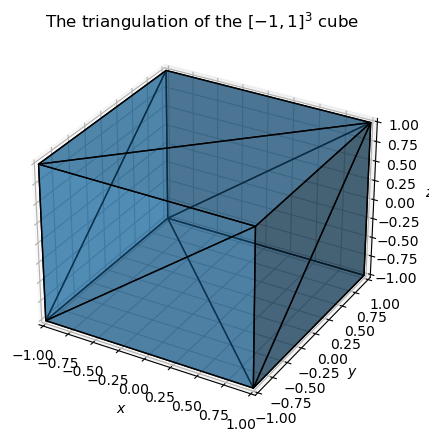

In [6]:
mesh_plotting.plot_triangulation(cube_vertices, cube_faces, "The triangulation of the $[-1,1]^3$ cube")

The interface is flexible and allows the evaluation of multiple points at once:


In [7]:
VALUES = np.arange(-2, 2.01, 0.005)
X = VALUES
Y = VALUES

computation_points = np.array(np.meshgrid(X, Y, [0])).T.reshape(-1, 3)
gravity_results = evaluate(
    polyhedron=cube_polyhedron,
    computation_points=computation_points,
)

Plotting the potential for the cube for the layer $(x, y, 0)$ with $x, y \in \mathbb{R}$


Plotting Grid 2D


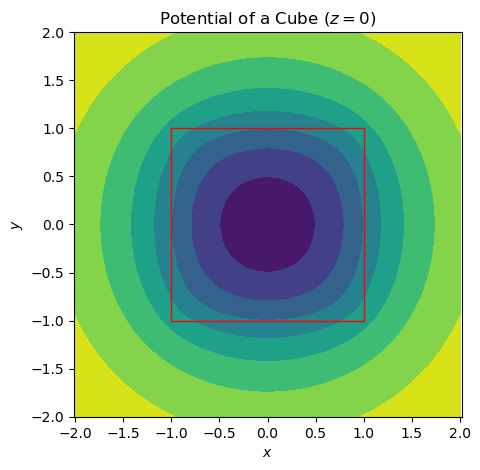

In [8]:
potentials = -1 * np.array([i[0] for i in gravity_results])
potentials = potentials.reshape((len(VALUES), len(VALUES)))

X = computation_points[:, 0].reshape(len(VALUES), -1)
Y = computation_points[:, 1].reshape(len(VALUES), -1)

mesh_plotting.plot_grid_2d(X, Y, potentials, "Potential of a Cube ($z=0$)", plot_rectangle=True)

Now, let's plot the acceleration in $x$ and $y$ directions. One should see the distortion of the streamlines at the edges of the cube.


Plotting Quiver


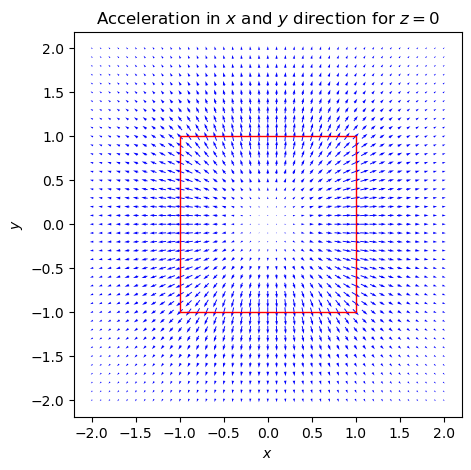

In [9]:
# We use for this plot a more coarse grid to improve the visualization
VALUES = np.arange(-2, 2.01, 0.1)
X = VALUES
Y = VALUES

computation_points = np.array(np.meshgrid(X, Y, [0])).T.reshape(-1, 3)
gravity_results = evaluate(
    polyhedron=cube_polyhedron,
    computation_points=computation_points,
)

accelerations = np.array([i[1][:] for i in gravity_results])
acc_xy = np.delete(accelerations, 2, 1)
acc_xy = -1 * acc_xy

X = computation_points[:, 0].reshape(len(VALUES), -1)
Y = computation_points[:, 1].reshape(len(VALUES), -1)

mesh_plotting.plot_quiver(X, Y, acc_xy, "Acceleration in $x$ and $y$ direction for $z=0$", plot_rectangle=True)

## Next some bigger example: Eros

Here, we can test the convenient feature of giving file input to the polyhedral gravity model's Python interface.
Further, the units are not correct, since the mesh size in unknown.

**Important Note:** If the polyhedron is located in two files (like for .node and .face files), the node files needs to be placed first in the list! If it is just a single file (e.g. .ply), then list just contains this single element.

**Important Note:** The employed mesh of Eros here is unitless! Thus, units are not a concern here. Its just a demonstration of the interface.

Further, we also make use of the `GravityEvaluable` class, which allows us to efficiently evaluate the gravity tensor for multiple computation points at once, even with interruptions in between. Certain computed properties are cached and reused.
We also know this mesh and that all normals are `OUTWARDS` pointing. So we don't need the mesh check and `DISABLE` it.


In [10]:
eros_vertices_path = "mesh/Eros.node"
eros_faces_path = "mesh/Eros.face"
density = 2670.0

eros_polyhedron = Polyhedron(
    polyhedral_source=[eros_vertices_path, eros_faces_path],
    density=density,
    normal_orientation=NormalOrientation.OUTWARDS,
    integrity_check=PolyhedronIntegrity.DISABLE,
)


computation_point = np.array([0, 0, 0])  # m

# The differende betweeen array input & file input lies in the types
# Array Mesh Input ==> tuple of arrays/ lists
# File Mesh Input ==> list of string file paths
evaluable_eros = GravityEvaluable(eros_polyhedron)

# Call the evaluable object with the computation point(s) and optionally disable/ enable parallelization
potential, acceleration, tensor = evaluable_eros(computation_points=computation_point, parallel=True)

print("Potential: {}".format(potential))
print("Acceleration [Vx, Vy, Vz]: {}".format(acceleration))
print("Second derivative tensor [Vxx, Vyy, Vzz, Vxy, Vxz, Vyz]: {}".format(tensor))

Potential: 1.6412193813901074e-07
Acceleration [Vx, Vy, Vz]: [-2.4104224440030084e-09, -3.9101840968470165e-08, -9.039023451764005e-09]
Second derivative tensor [Vxx, Vyy, Vzz, Vxy, Vxz, Vyz]: [-1.2243921287729791e-07, -1.1414944948899626e-06, -9.754414135835843e-07, -3.86381487022689e-08, 1.3548134599015306e-08, -2.6597490639550815e-08]


Of course again, we can also give an array of points to the calculation to evaluate the gravity model for multiple points at once.


In [11]:
X = np.arange(-1.0, 1.05, 0.05)
Y = np.arange(-1.0, 1.05, 0.05)

computation_points = np.array(np.meshgrid(X, Y, [0])).T.reshape(-1, 3)
gravity_results = evaluable_eros(computation_points)

Plotting the potential for Eros:


Plotting Grid 2D


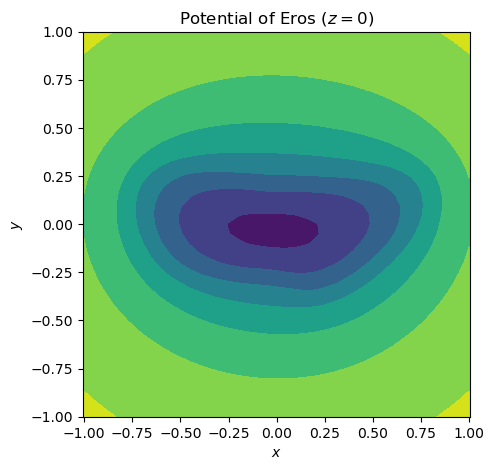

In [12]:
potentials = -1 * np.array([i[0] for i in gravity_results])
potentials = potentials.reshape((len(VALUES), len(VALUES)))

X = computation_points[:, 0].reshape(len(VALUES), -1)
Y = computation_points[:, 1].reshape(len(VALUES), -1)

mesh_plotting.plot_grid_2d(X, Y, potentials, "Potential of Eros ($z=0$)")

And the acceleration for the slice with $z = 0$:


Plotting Quiver


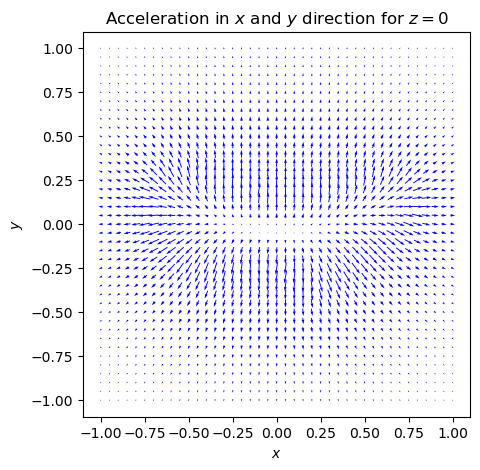

In [13]:
accelerations = np.array([i[1][:] for i in gravity_results])
acc_xy = np.delete(accelerations, 2, 1)
acc_xy = -1 * acc_xy

mesh_plotting.plot_quiver(X, Y, acc_xy, "Acceleration in $x$ and $y$ direction for $z=0$")

# Next example: Torus

All good thrings come in threes, so let's try another example.

Here, we use some additional utility to read in the vertices and triangles from the `.pk` file since this file format is not directly supported through the python interface. Additionally, we can plot the Torus, since we have the "raw" vertices and faces directly in Python.
Agian, we know this mesh and that all normals are `OUTWARDS` pointing. So we don't need the mesh check and `DISABLE` it.


Plotting Triangulation


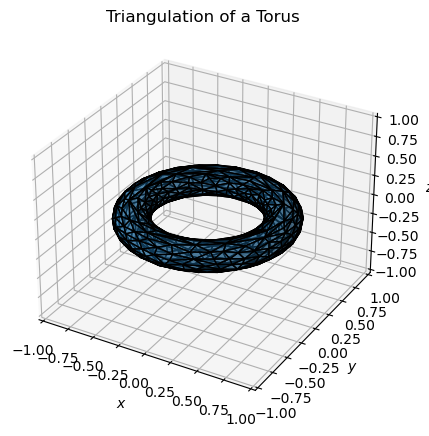

In [14]:
import mesh_utility

torus_vertices, torus_faces = mesh_utility.read_pk_file("mesh/torus_lp.pk")
density = 1.0
torus_polyhedron = Polyhedron(
    (torus_vertices, torus_faces), density, NormalOrientation.OUTWARDS, PolyhedronIntegrity.DISABLE
)


torus_evaluable = GravityEvaluable(torus_polyhedron)

mesh_plotting.plot_triangulation(torus_vertices, torus_faces, "Triangulation of a Torus")

In [15]:
X = np.arange(-1.0, 1.05, 0.01)
Y = np.arange(-1.0, 1.05, 0.01)

computation_points = np.array(np.meshgrid(X, Y, [0])).T.reshape(-1, 3)
gravity_results = torus_evaluable(computation_points)

Below, you find two alternative ways to plot potential and acceleration.


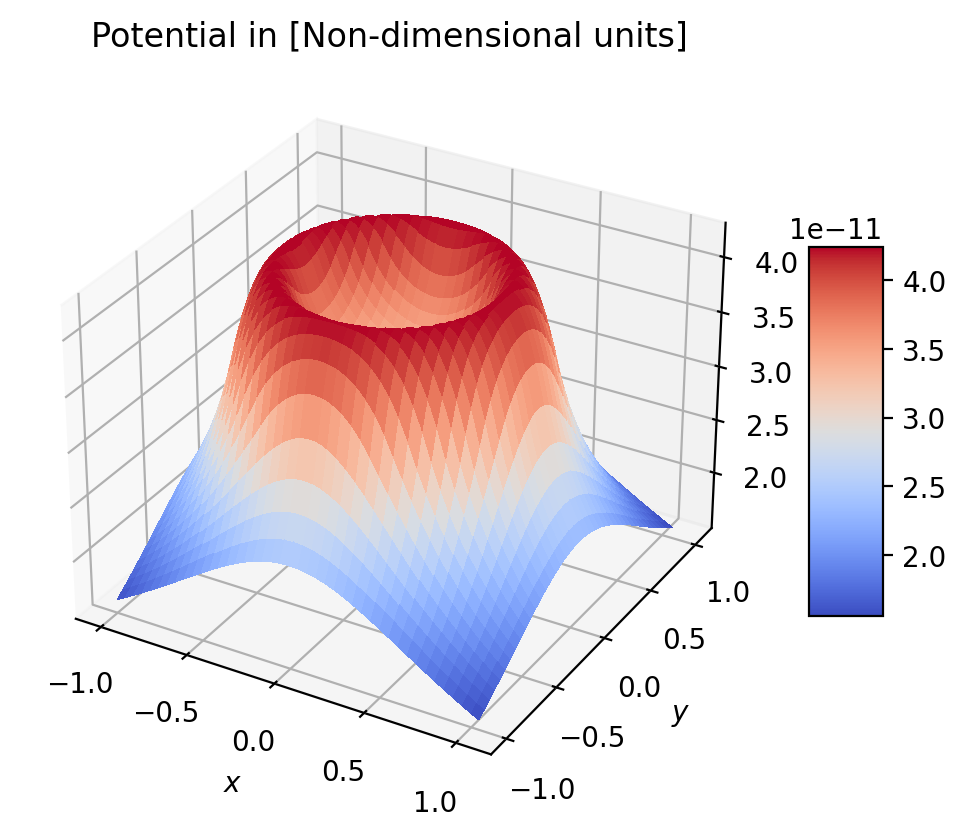

In [16]:
# Extracting the potential from our result
potentials = np.array([i[0] for i in gravity_results])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X, Y = np.meshgrid(X, Y)
Z = potentials.reshape((len(X), len(Y)))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_title("Potential in [Non-dimensional units]")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

# Add a color bar which maps values to colors.
fig.colorbar(surf, aspect=5, orientation="vertical", shrink=0.5)

fig.set_dpi(200)

plt.show()

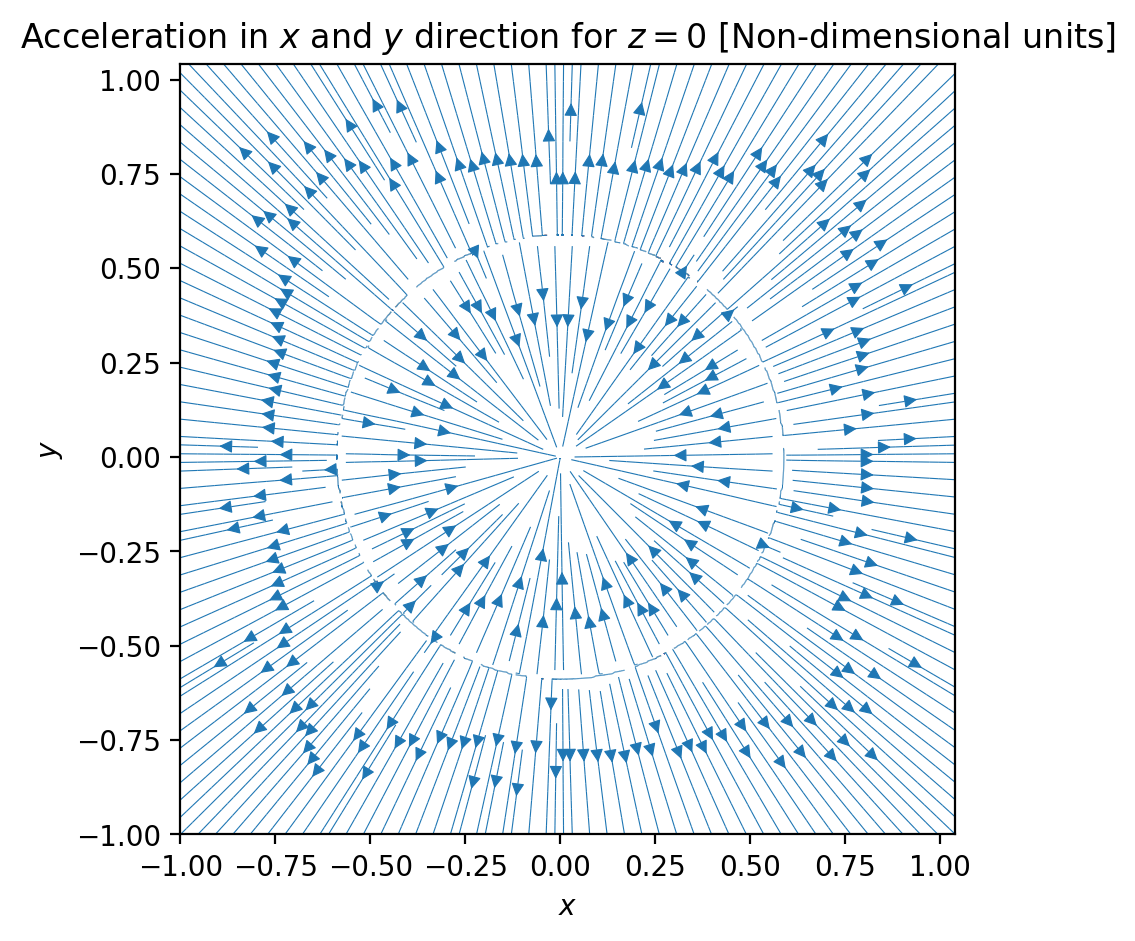

In [17]:
# We just want a slice of x, y values for z = 0
accelerations = np.array([i[1][:] for i in gravity_results])
accelerations = np.delete(accelerations, 2, 1)

accelerations = -1 * accelerations


fig, ax = plt.subplots()

U = np.reshape(accelerations[:, 0], (len(X), -1))
V = np.reshape(accelerations[:, 1], (len(Y), -1))

# Streamplot
plt.streamplot(X, Y, V, U, density=3, linewidth=0.4)

ax.set_title("Acceleration in $x$ and $y$ direction for $z=0$ [Non-dimensional units]")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

fig.set_dpi(200)
fig.set_size_inches((5, 5))

plt.show()

## Further reference

For additional examples and the full API of the Python Interface (and C++ interface) refer to the [documentation](https://esa.github.io/polyhedral-gravity-model/).
